In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [2]:
!ln -s /content/gdrive/MyDrive/ /mydrive2

In [3]:
import os
features =  24
levels =  5

epochs = 10#@param
batch_size =  8#@param
learning_rate = 9e-4 #@param
seed = 2202
SIZE = 320
RUN_ID = 1 #@param {type:"slider", min:0, max:9, step:1}


calibration = False  #@param {type:"boolean"}
pretraining = True  #@param {type:"boolean"}
augmentation = True  #@param {type:"boolean"}

dataset = f"data"
data_main = "results"


weigths_path = f'/{data_main}/weights/run=3.h5'
tmp_weigths_path = f'/tmp/temp_run=3.h5'

train_path = os.path.join(dataset, 'ImageSets', 'Cross', f'train_10.txt')
val_path = os.path.join(dataset, 'ImageSets', 'Cross', f'val_10.txt')

#Definition of the U-Net model

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import *


KERNEL_REGUL = tf.keras.regularizers.l2(1e-8)


class convBlock(tf.keras.layers.Layer):
    def __init__(self, feature, **kwargs):
        super(convBlock, self).__init__(**kwargs)

        self.conv = Conv2D(feature, 3, activation=None, kernel_initializer='he_uniform',
                            padding="same", kernel_regularizer=KERNEL_REGUL)

        self.bn = BatchNormalization()

        self.relu = ReLU()

    def get_config(self):
        return super().get_config()

    def call(self, inputs):
        outputs = self.conv(inputs)
        outputs = self.bn(outputs)
        outputs = self.relu(outputs)
        return outputs


class inputBlock(tf.keras.layers.Layer):
    def __init__(self, F, **kwargs):
        super(inputBlock, self).__init__(**kwargs)

        self.conv1 = convBlock(F)
        self.conv2 = convBlock(F)

    def get_config(self):
        return super().get_config()

    def call(self, inputs):

        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)

        return outputs


class downBLock(tf.keras.layers.Layer):
    def __init__(self, F, lvl, **kwargs):
        super(downBLock, self).__init__(**kwargs)

        feature = F*(2**lvl)
        self.down = MaxPooling2D(pool_size=(2, 2))
        self.conv1 = convBlock(feature)
        self.conv2 = convBlock(feature)

    def get_config(self):
        return super().get_config()

    def call(self, inputs):

        outputs = self.down(inputs)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)

        return outputs


class blottleBlock(tf.keras.layers.Layer):
    def __init__(self, F, lvl, **kwargs):
        super(blottleBlock, self).__init__(**kwargs)

        feature = F*(2**lvl)
        self.down = MaxPooling2D(pool_size=(2, 2))
        self.conv1 = convBlock(feature)
        self.conv2 = convBlock(feature)

    def get_config(self):
        return super().get_config()

    def call(self, inputs):

        outputs = self.down(inputs)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)

        return outputs


class upBlock(tf.keras.layers.Layer):
    def __init__(self, F, lvl, **kwargs):
        super(upBlock, self).__init__(**kwargs)

        feature = F*(2**lvl)
        self.up = UpSampling2D(size=(2, 2))
        # self.up = Conv2DTranspose(feature, 2, strides=(2,2) , padding='same')
        self.concat = Concatenate()
        self.conv1 = convBlock(feature)
        self.conv2 = convBlock(feature)
    def get_config(self):
        return super().get_config()

    def call(self, inputs):

        outputs = self.up(inputs[0])
        outputs = self.concat([outputs, inputs[1]])
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)

        return outputs

class outBlock(tf.keras.layers.Layer):
    def __init__(self, F, **kwargs):
        super(outBlock, self).__init__(**kwargs)

        # self.up = Conv2DTranspose(F, 2, strides=(2,2) , padding='same')
        self.up = UpSampling2D(size=(2, 2))
        self.concat = Concatenate()
        self.conv1 = convBlock(F)
        self.conv2 = convBlock(F)

    def get_config(self):
        return super().get_config()

    def call(self, inputs):

        outputs = self.up(inputs[0])
        outputs = self.concat([outputs, inputs[1]])
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)

        return outputs

In [5]:
import tensorflow as tf
from tensorflow.python.keras.layers.core import Lambda
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Conv2D, Reshape

class UnetLayer(tf.keras.layers.Layer):
    def __init__(self, feature, levels, **kwargs):

        self.feature = feature
        self.levels = levels

        super().__init__(**kwargs)

        self.inputBlock = inputBlock(feature)
        self.downBlocks = [ downBLock(feature,level) for level in range(1,levels)  ]
        self.blottleBlock = blottleBlock(feature, levels)
        self.upBlocks = [ upBlock(feature,levels - level) for level in range(1,levels)]
        self.outBlock = outBlock(feature)

    def get_config(self):
        config = super().get_config()
        config['feature'] = self.feature
        config['levels'] = self.levels
        return config

    def call(self, inputs):

        outputs = []
        x = self.inputBlock(inputs)
        outputs.append(x)

        for downlayer in self.downBlocks:
            x = downlayer(x)
            outputs.append(x)

        x = self.blottleBlock(x)

        for uplayer in self.upBlocks:
            y = outputs.pop(-1)
            x = uplayer([x,y])

        y = outputs.pop(-1)
        x = self.outBlock([x,y])

        return x

def Unet(input_shape, feature=8, levels=3, num_classes=3):

    _input = Input(input_shape)

    unet = UnetLayer(feature, levels)(_input)

    _output = Conv2D(1, 1, activation='sigmoid', padding="same")(unet)
    # _output = Lambda( lambda x:  tf.argmax( x , -1) )(_output)

    model = Model(_input, _output, name="Unet")
    return model

#Creation of the cropped masks and cropped wounds

In [6]:
#Extract images and mask
!unzip /mydrive2/Segmentation:U-Net_2DB/data/images_yolo.zip -d /mydrive2/Segmentation:U-Net_2DB/data/

Archive:  /mydrive2/Segmentation:U-Net_2DB/data/images_yolo.zip
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG507.jpg  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG507.txt  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG509.jpg  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG509.txt  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG532.jpg  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG532.txt  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG533.jpg  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG533.txt  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG534.jpg  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG534.txt  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/images_yolo/ADANIMG698.jpg  
  inflating: /mydrive2/Segmentation:U-Net_2DB/data/image

In [ ]:
!unzip /mydrive2/Segmentation:U-Net_2DB/data/mask.zip -d /mydrive2/Segmentation:U-Net_2DB/data/

Archive:  /mydrive2/Segmentation:U-Net_2DB/data/mask.zip
replace /mydrive2/Segmentation:U-Net_2DB/data/mask/ADANIMG507.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import json

def extract_roi(image, bbox, margin_pixels=30):
    # Convert normalized coordinates to absolute coordinates
    center_x, center_y, width, height = bbox
    left = int((center_x - width / 2) * image.shape[1])
    top = int((center_y - height / 2) * image.shape[0])
    right = int((center_x + width / 2) * image.shape[1])
    bottom = int((center_y + height / 2) * image.shape[0])

    # Add margin to the coordinates
    left_margin = max(0, left - margin_pixels)
    top_margin = max(0, top - margin_pixels)
    right_margin = min(image.shape[1], right + margin_pixels)
    bottom_margin = min(image.shape[0], bottom + margin_pixels)

    # Crop the image
    cropped_image = image[top_margin:bottom_margin, left_margin:right_margin]

    if len(cropped_image.shape) == 3:
      cropped_image = tf.image.resize(cropped_image, [SIZE, SIZE]).numpy()
    else:
      cropped_image = cv2.resize(cropped_image, (SIZE, SIZE))
    return cropped_image

In [8]:
# Load predictions from your JSON file
with open("/mydrive2/Segmentation:U-Net_2DB/my_predictions.txt", 'r') as file:
    predictions = json.load(file)

# Directory to save cropped images
output_rgb_directory = '/mydrive2/Segmentation:U-Net_2DB/data/cropped_images/'
output_mask_directory = '/mydrive2/Segmentation:U-Net_2DB/data/cropped_masks/'

# Create the output directory if it doesn't exist
os.makedirs(output_rgb_directory, exist_ok=True)
os.makedirs(output_mask_directory, exist_ok=True)

# List to store cropped images
cropped_images_list = []
cropped_masks_list = []
original_sizes = []
len_images_liste = 0
i = 0
# Iterate through predictionsa
for prediction in predictions:
    frame_id = prediction['frame_id']
    filename = "/mydrive2/Segmentation:U-Net_2DB/" + prediction["filename"]
    objects = prediction['objects']
    image = cv2.imread(filename)

    mask_filename = prediction["filename"].replace("images_yolo", "mask").replace(".jpg", ".png")
    mask_filename = f"/mydrive2/Segmentation:U-Net_2DB/" + mask_filename
    mask = cv2.imread(mask_filename, cv2.IMREAD_GRAYSCALE)

    if mask is not None:
        cropped_objects = set()
        # Iterate through objects in the current frame
        for obj in objects:
            label = obj["name"]
            confidence = obj["confidence"]
            bbox = obj["relative_coordinates"].values()
            base_filename = os.path.basename(filename)
            if confidence > 0.5:
                if label == 'wound':
                    if bbox not in cropped_objects:
                        cropped_objects.add(bbox)
                        cropped_image = extract_roi(image, bbox)
                        cropped_mask = extract_roi(mask, bbox)

                        # Save cropped mask to the output mask directory
                        output_image_filename = f"{base_filename}"
                        output_image_path = os.path.join(output_rgb_directory, output_image_filename)
                        cv2.imwrite(output_image_path, cropped_image)

                        original_sizes.append(mask.shape[:2])

                        output_mask_filename = f"{base_filename}"
                        output_mask_path = os.path.join(output_mask_directory, output_mask_filename)
                        cv2.imwrite(output_mask_path, cropped_mask)

                        # Append the cropped image and mask to the respective lists
                        cropped_images_list.append(cropped_image)
                        cropped_masks_list.append(cropped_mask)


In [ ]:
print(len(cropped_masks_list))
print(len(cropped_images_list))
print(len(original_sizes))

#Data augmentation to increase the number of images

In [10]:
def zoom_with_padding(image, zoom_factor, target_size=(SIZE, SIZE)):
    # Calculate the length of the image
    new_size = (int(image.shape[1] * zoom_factor), int(image.shape[0] * zoom_factor))

    # zoom without aspect change
    zoomed_image = cv2.resize(image, new_size)

    h_padding = max((target_size[0] - zoomed_image.shape[1]) // 2, 0)
    v_padding = max((target_size[1] - zoomed_image.shape[0]) // 2, 0)

    # Crée une image vide avec les dimensions cibles et remplit-la avec l'image agrandie
    if len(image.shape)==3:
      padded_image = np.zeros(target_size + (image.shape[2],), dtype=image.dtype)
    else:
      zoomed_image = zoomed_image[..., np.newaxis]
      padded_image = np.zeros(target_size + (1,), dtype=image.dtype)

    if v_padding != 0:
      padded_image[v_padding:v_padding + zoomed_image.shape[0], h_padding:h_padding + zoomed_image.shape[1]] = zoomed_image
    else:
      padded_image = cv2.resize(zoomed_image, (target_size[0], target_size[1]))
    return padded_image

In [11]:
import cv2
import numpy as np

# Fonction pour ajuster le contraste
def adjust_contrast(image, contrast_factor):
    # Convert image in float32 type
    image = image.astype(np.float32)
    # adjust contrast
    adjusted_image = image * contrast_factor
    # limit pixel value between 0 and 255
    adjusted_image = np.clip(adjusted_image, 0, 255)
    # Convert in uint8 type
    adjusted_image = adjusted_image.astype(np.uint8)
    return adjusted_image

In [12]:
zoom_factors = [0.8, 1.2]
angle_factors = [90, 180, -90]
contrast_factors = [0.8, 1.0, 1.2]

for cropped_image, cropped_mask, size in zip(cropped_images_list[:], cropped_masks_list[:], original_sizes):
    for zoom in zoom_factors:
        for rotation_angle in angle_factors:
            for contrast_factor in contrast_factors:
                # Applicate zoom and rotation on the image
                zoomed_out_rgb = zoom_with_padding(cropped_image, zoom)
                rotation_matrix_rgb = cv2.getRotationMatrix2D((zoomed_out_rgb.shape[1]/2, zoomed_out_rgb.shape[0]/2), rotation_angle, 1)
                rotated_rgb = cv2.warpAffine(zoomed_out_rgb, rotation_matrix_rgb, (zoomed_out_rgb.shape[1], zoomed_out_rgb.shape[0]))

                # Applicate zoom and rotation on the mask masque
                zoomed_out_mask = zoom_with_padding(cropped_mask, zoom)
                rotation_matrix_mask = cv2.getRotationMatrix2D((zoomed_out_mask.shape[1]/2, zoomed_out_mask.shape[0]/2), rotation_angle, 1)
                rotated_mask = cv2.warpAffine(zoomed_out_mask, rotation_matrix_mask, (zoomed_out_mask.shape[1], zoomed_out_mask.shape[0]))

                # Adjust contrast
                adjusted_rgb = adjust_contrast(rotated_rgb, contrast_factor)

                # Ajouter les images et les masques résultants aux listes
                cropped_images_list.append(adjusted_rgb)
                cropped_masks_list.append(rotated_mask)
                original_sizes.append(size)

In [ ]:
print(len(cropped_images_list))
print(len(cropped_masks_list))
print(len(original_sizes))

In [ ]:
for i in range(20):
  cv2_imshow(cropped_images_list[i])
  cv2_imshow(cropped_masks_list[i])

# Creation of the test and train database

In [14]:
from sklearn.model_selection import train_test_split
X = np.array(cropped_images_list)
y = np.array(cropped_masks_list)
y = y[..., np.newaxis]
y = y / 255

In [15]:
X_train, X_test, y_train, y_test, original_sizes_train, original_sizes_test = train_test_split(X, y, original_sizes, test_size=0.25, random_state=42)

In [16]:
# Créez un tableau NumPy pour l'ensemble de test
X_test = np.array(X_test)
y_test = np.array(y_test)

# Forme des données de test
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (5101, 320, 320, 3)
Shape of y_train: (5101, 320, 320, 1)
Shape of X_test: (1701, 320, 320, 3)
Shape of y_test: (1701, 320, 320, 1)


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import RandomContrast, RandomZoom, RandomFlip


DEFAULT_SIZE = 320


class DataGen(tf.data.Dataset):

    def _generator(Xtrain, ytrain):
        for x, y in zip(Xtrain, ytrain):
            yield (x, y)

    def __new__(cls, input_size=(640, 640), dataset=None):

        x_size = input_size + (3,)
        y_size = input_size + (3,)
        output_signature = (tf.TensorSpec(shape=x_size, dtype=tf.float32),
                            tf.TensorSpec(shape=y_size, dtype=tf.float32))

        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=output_signature,
            args=dataset
        )


def resize(x, size):
    return tf.image.resize(x, [size, size])


def process_augmentation(x, y, SIZE=DEFAULT_SIZE):

    random_size = int(tf.random.uniform(shape=[1], minval=0.9)*SIZE)[0]

    img = tf.stack([x, y])
    img = tf.image.random_crop(img, [2, 1, random_size, random_size, 3])
    img = tf.transpose(img, perm=[1, 0, 2, 3, 4])
    img = tf.map_fn(lambda x: resize(x, SIZE), img)
    img = tf.transpose(img, perm=[1, 0, 2, 3, 4])
    return img[0], img[1][..., 0, None]


def get_coords(y, augmented=False):
        y = tf.reduce_max(y, axis=-1)
        # HEIGTH AND WIDTH SEGMENTATIN DELIMITATIONS
        h_args = tf.where(tf.reduce_max(y, axis=1) > 0)
        w_args = tf.where(tf.reduce_max(y, axis=0) > 0)

        # TOP-LEFT BBOX AND HEIGTH AND WIDTH CALCULATION
        min_h, min_w = h_args[0], w_args[0]
        heigth, width = h_args[-1] - min_h, w_args[-1] - min_w

        heigth = tf.cast(heigth, tf.int32)
        width = tf.cast(width, tf.int32)

        # SQUARE SIZE FOR BOX CALCULATION
        target_size = tf.maximum(width[0], heigth[0])


        if augmented:
            factor = 0.4  # HYPERPARAMETRO
            target_size = tf.cast(target_size, tf.float32)
            zoom_factor = 1 + tf.multiply(tf.random.uniform([1]) - 0.5, factor)
            target_size = tf.cast(target_size*zoom_factor, tf.int32)

        min_h, min_w = tf.cast(min_h, tf.int32)[0], tf.cast(min_w, tf.int32)[0]

        # OFFSET FOR CENTER SEGMENTATION
        offset_h = tf.cast((target_size - heigth)/2, tf.int32)[0]
        offset_w = tf.cast((target_size - width)/2, tf.int32)[0]

        # NEW_CORDS CASE: NEW BOX OUT OF THE IMAGE SIZE
        cord_h = tf.squeeze( tf.maximum(0, min_h - offset_h) )
        cord_w = tf.squeeze( tf.maximum(0, min_w - offset_w) )

        # NEW SIZE CASE: NEW BOX OUT OF THE IMAGE SIZE
        h_size = tf.squeeze( tf.minimum(640 - cord_h, target_size) )
        w_size = tf.squeeze( tf.minimum(640 - cord_w, target_size) )

        return cord_h, cord_w, h_size, w_size

def prepare_data(x, y, detection=True, augmented=False, SIZE=DEFAULT_SIZE, original=False):

    # SEGMENTATION MASK TO 1 CHANNEL DIMENSION

    y_crop = y
    if detection:

        cord_h, cord_w, h_size, w_size = get_coords(y, augmented=augmented)
        # CROPPING IMAGE AND SEGMENTATION
        x = tf.image.crop_to_bounding_box(x, cord_h, cord_w, h_size, w_size)
        y_crop = tf.image.crop_to_bounding_box(y_crop, cord_h, cord_w, h_size, w_size)

    # RESIZE IMAGE TO DEFINED DEFAULT SIZE
    x = tf.image.resize(x, (SIZE, SIZE))
    y_crop = tf.image.resize(y_crop, (SIZE, SIZE))

    if original:
        return x, (y_crop, y)

    return x, y_crop


def data_pipeline(dataset, SIZE=DEFAULT_SIZE, batch_size=8, contrast_factor=0.25, augmented=False, detection=False, original=False):

    contrast = tf.keras.Sequential([
        RandomContrast(factor=contrast_factor),
    ])

    train_ds = tf.data.Dataset.zip( dataset )
    train_ds = train_ds.cache('')

    train_ds = train_ds.map(lambda x, y:  prepare_data(x, y, augmented=augmented, detection=detection, original=original),
                num_parallel_calls= tf.data.AUTOTUNE)

    train_ds = train_ds.batch(batch_size, drop_remainder=True)

    if augmented:
        train_ds = train_ds.map(lambda x, y: (contrast(x), y ),
                    num_parallel_calls= tf.data.AUTOTUNE)

    train_ds = train_ds.prefetch(10)

    return train_ds



In [18]:
import os
import numpy as np
import cv2
import tensorflow as tf


def iou_coef(y_true, y_pred, smooth=1e-5):
    th = 0.5
    y_pred = tf.cast(y_pred > th, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, [1, 2, 3]) + \
        tf.reduce_sum(y_pred, [1, 2, 3])-intersection
    iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)

    return iou


def dice_coef(y_true, y_pred, smooth=1e-5):
    th = 0.5
    y_pred = tf.cast(y_pred > th, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1, 2, 3])
    denom = tf.reduce_sum(y_true, [1, 2, 3]) + tf.reduce_sum(y_pred, [1, 2, 3])
    dice = tf.reduce_mean((2*intersection + smooth) / (denom + smooth), axis=0)

    return dice

#U-Net model initialization and training

In [19]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

In [20]:
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    ModelCheckpoint,
    EarlyStopping)

input_shape = (320, 320, 3)
model = Unet(input_shape, features, levels)

callbacks = [ReduceLROnPlateau(verbose=1,
                              patience=20,
                              factor=0.98,
                              monitor='loss'),
             ModelCheckpoint(f'/mydrive2/Segmentation:U-Net_2DB/results/weights_2DB_5.h5',
                             monitor='val_dice_coef',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='max')]
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [21]:
model.summary()

Model: "Unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 unet_layer (UnetLayer)      (None, 320, 320, 24)      17705832  
                                                                 
 conv2d_22 (Conv2D)          (None, 320, 320, 1)       25        
                                                                 
Total params: 17705857 (67.54 MB)
Trainable params: 17696833 (67.51 MB)
Non-trainable params: 9024 (35.25 KB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[ dice_coef, Precision(), Recall(), 'accuracy'])
model.summary()

# Étape 4 : Entraînement du modèle
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, validation_data=(X_test, y_test))

Model: "Unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 unet_layer (UnetLayer)      (None, 320, 320, 24)      17705832  
                                                                 
 conv2d_22 (Conv2D)          (None, 320, 320, 1)       25        
                                                                 
Total params: 17705857 (67.54 MB)
Trainable params: 17696833 (67.51 MB)
Non-trainable params: 9024 (35.25 KB)
_________________________________________________________________
Epoch 1/10
638/638 [==============================] - 237s 325ms/step - loss: 0.2507 - dice_coef: 0.6000 - precision: 0.7372 - recall: 0.6150 - accuracy: 0.8866 - val_loss: 0.2975 - val_dice_coef: 0.6464 - val_precision: 0.6094 - val_recall: 0.8551 - val_accuracy: 0.8687 - lr: 9.00

In [22]:
model.load_weights(f'/mydrive2/Segmentation:U-Net_2DB/results/weights_2DB_5.h5')

In [ ]:
model.save(f'/mydrive2/Segmentation:U-Net_2DB/results/weights_2DB_5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Test part

In [23]:
import matplotlib.pyplot as plt
import csv

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

save_folder1 = "/mydrive2/Segmentation:U-Net_2DB/results/predictions/mask"
save_folder2 = "/mydrive2/Segmentation:U-Net_2DB/results/predictions/compare"
save_path1 = os.path.join(save_folder1, f"run{RUN_ID}")
save_path2 = os.path.join(save_folder2, f"run{RUN_ID}")

if not os.path.exists(save_folder1):
    os.mkdir(save_folder1)
    os.mkdir(save_folder2)

if not os.path.exists(save_path1):
    os.mkdir(save_path1)
    os.mkdir(save_path2)

csv_file = os.path.join("/mydrive2/Segmentation:U-Net_2DB/results", "y_pred.csv")

id = 0
for x, y, original_size in zip(X_test, y_test, original_sizes_test):
    cv2_imshow(x)
    # Reshape input image for model prediction
    x_input = np.expand_dims(x, axis=0)
    # Predict using the model
    y_pred = model.predict(x_input)
    y_pred = tf.image.resize(y_pred, [x.shape[0], x.shape[1]])
    y_pred = y_pred.numpy()
    y_pred = 1 * (y_pred > 0.5)
    temp = np.squeeze(np.uint8(y_pred[0] * 255))

    # Create an empty mask with the correct shape
    y_pred_resized = np.zeros((x.shape[0], x.shape[1], 1), dtype=np.uint8)
    y_pred_resized[:, :, 0] = temp

    # Resize predicted mask back to the original dimensions
    y_pred_resized = cv2.resize(y_pred_resized, (original_size[1], original_size[0]))
    y_resized = cv2.resize(y, (original_size[1], original_size[0]))

    # Mask Binarisation
    y_resized *= 255
    _, y_resized_mask = cv2.threshold(y_resized, 127, 255, cv2.THRESH_BINARY)
    _, y_pred_binarized = cv2.threshold(y_pred_resized, 127, 255, cv2.THRESH_BINARY)

    # Calculate differences between masks
    TP = np.logical_and(y_resized_mask, y_pred_binarized)
    FP = np.logical_and(np.logical_not(y_resized_mask), y_pred_binarized)
    FN = np.logical_and(y_resized_mask, np.logical_not(y_pred_binarized))
    TN = np.logical_and(np.logical_not(y_resized_mask), np.logical_not(y_pred_binarized))

    # Define color for each type of pixel
    color_TP = [255, 0, 0]  # Red for true positiv
    color_FP = [0, 255, 0]  # Green for false positive
    color_FN = [0, 0, 255]  # Blue for false negative

    # Create an empty RGB image to stock differences
    diff_image = np.zeros((*y_resized_mask.shape, 3), dtype=np.uint8)

    # Color pixels
    diff_image[TP] = color_TP
    diff_image[FP] = color_FP
    diff_image[FN] = color_FN
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(y_resized_mask, cmap='gray')
    axes[0].set_title("Real mask")

    axes[1].imshow(y_pred_resized, cmap='gray')
    axes[1].set_title("Predicted mask")

    axes[2].imshow(diff_image, cmap='gray')
    axes[2].set_title("Difference between real and predict mask")

    legend_elements = [
      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10, label='True Positive (TP)'),
      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=10, label='False Positive (FP)'),
      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10, label='False Negative (FN)')
    ]
    axes[2].legend(handles=legend_elements, loc='upper right')


    plt.show()

    img_save1 = f"segmented_{id}.png"
    img_path1 = os.path.join(save_path1, img_save1)

    img_save2 = f"compare_{id}.png"
    img_path2 = os.path.join(save_path2, img_save2)

    cv2.imwrite(img_path1, y_pred_resized)
    cv2.imwrite(img_path2, diff_image)

    id += 1


#Convert .h5 model to tflite

In [ ]:
model.load_weights(f'/mydrive2/Segmentation:U-Net_2DB/results/weights_2DB_5.h5')

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/mydrive2/Segmentation:U-Net_2DB/results/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter('/mydrive2/Segmentation:U-Net_2DB/results/model.tflite')

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#Test modèle tflite

In [ ]:
interpreter.allocate_tensors()

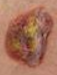

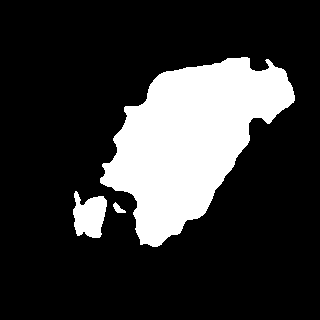

In [ ]:
import cv2
import numpy as np

image_path = "/mydrive2/Segmentation:U-Net_2DB/test.png"
image = cv2.imread(image_path)

cv2_imshow(image)
cv2.waitKey(0)

desired_size = (320, 320)
image = cv2.resize(image, desired_size)

x_input = np.expand_dims(image, axis=0)

# Convert input data to FLOAT32
x_input_float32 = x_input.astype(np.float32)

interpreter.set_tensor(input_details[0]['index'], x_input_float32)
interpreter.invoke()
y_pred = interpreter.get_tensor(output_details[0]['index'])

y_pred_resized = cv2.resize(y_pred[0], (image.shape[1], image.shape[0]))

y_pred_binarized = np.uint8(y_pred_resized > 0.5) * 255

cv2_imshow(y_pred_binarized)
cv2.waitKey(0)
cv2.destroyAllWindows()
